# Launch!

 - Get your solution ready for production (plug into production data inputs, write unit tests, etc.).
 - Write monitoring code to check your system's live performance at regular intervals and trigger alerts when it drops.
 - Beware of slow degradation: models tend to "rot" as data evolves.
 - Measuring performance may require a human pipeline (e.g., via a crowdsourcing service).
 - Also monitor your inputs' quality (e.g., a malfunctioning sensor sending random values, or another team's output becoming stale). This is particularly important for online learning systems.
 - Retrain your models on a regular basis on fresh data (automate as much as possible).

---

Using Trained model I preprare a table containing cosine distances showing similarity between chosen restaurant and all other restaurants.

---

In [468]:
# Here I use Kaggle process final similarity table
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/combined-p4/combined_business_data_3_p4.pkl
/kaggle/input/my-keras-model/my_keras_model.h5
/kaggle/input/combined-business-data-p4/combined_business_data_p4.pkl
/kaggle/input/combined-business-data-3/combined_business_data_3.pkl
/kaggle/input/combined-business-data-2pkl/combined_business_data_2.pkl


In [469]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Dropout, AlphaDropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam

from tensorflow import keras
from tqdm import tqdm

# from keras.optimizers import Adam
from keras.regularizers import l2

import math

# Set printing in non scientific notation
np.set_printoptions(suppress=True)


Load Model

In [470]:
# # Restore / Load Saved Model
# keras_model = keras.models.load_model("my_keras_model__big_dataset_bath_normalization.h5")


In [471]:
# Restore / Load Saved Model
keras_model = keras.models.load_model("/kaggle/working/my_keras_model.h5")


Plot Loaded Model

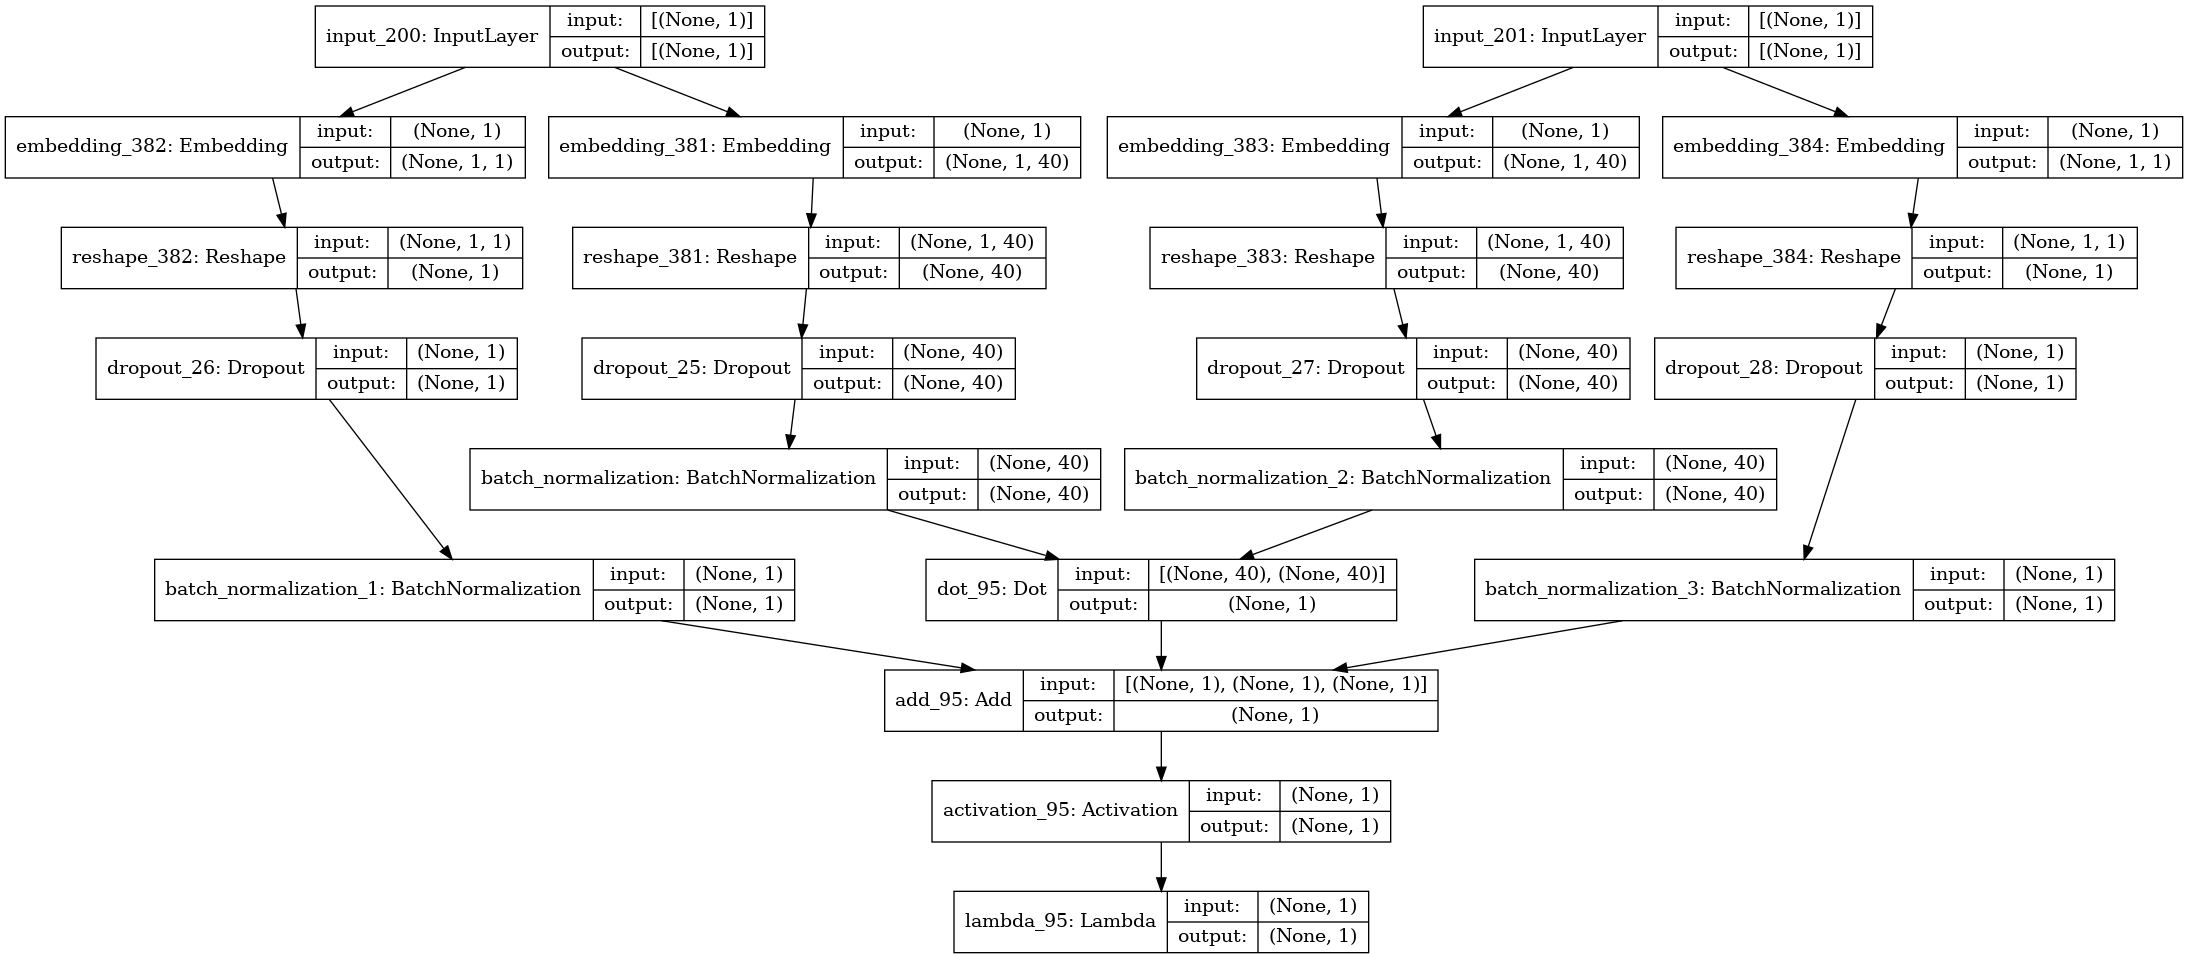

In [472]:
# Plot Model
from keras.utils.vis_utils import plot_model

plot_model(keras_model, show_shapes=True)


Load Pickled Data

In [473]:
# combined_business_data = pd.read_pickle("combined_business_data.pkl")
# combined_business_data.head(2)

In [474]:
# Data Are now on Kaggle
combined_business_data = pd.read_pickle("/kaggle/input/combined-p4/combined_business_data_3_p4.pkl")
combined_business_data.head(2)

,user_id,business_id,stars,date,name,address,user,business
0,nOTl4aPC4tKHK35T3bNauQ,xVEtGucSRLk5pxxN0t4i6g,5.0,2012-08-23,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",174531,3044
1,l0-VQ8nA_oijpKlRB7dkow,xVEtGucSRLk5pxxN0t4i6g,4.0,2010-02-11,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",166468,3044


Extract embeddings for Restaurants

In [475]:
# %%
# Extract embeddings
emb = keras_model.get_layer("embedding_383")
emb_weights = emb.get_weights()[0]

print("The shape of embedded weights: ", emb_weights.shape)
print("The length of embedded weights: ", len(emb_weights))

The shape of embedded weights:  (3173, 40)
The length of embedded weights:  3173


In [476]:
emb_weights

array([[-0.04605037, -0.03618775,  0.05068509, ..., -0.01739551,
         0.11320017,  0.07238425],
       [-0.10586792, -0.12006937,  0.10964748, ..., -0.12735452,
         0.03112674,  0.09909911],
       [-0.05259788, -0.06362671,  0.10979109, ...,  0.00708825,
        -0.09788586,  0.07875273],
       ...,
       [ 0.00667695, -0.03053323,  0.10997368, ..., -0.00815215,
        -0.00554256,  0.03220698],
       [-0.09927268,  0.01115802, -0.11352655, ..., -0.02727613,
        -0.01198951, -0.02889238],
       [ 0.04796723, -0.09704581,  0.06329688, ..., -0.05304937,
         0.03657529,  0.06403198]], dtype=float32)

In [477]:
# normalize and reshape embedded weights
emb_weights_normalized_reshaped = emb_weights / np.linalg.norm(
    emb_weights, axis=1
).reshape(
    (-1, 1),
)
emb_weights_normalized_reshaped


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


array([[-0.08694329, -0.06832262,  0.09569365, ..., -0.0328428 ,
         0.2137224 ,  0.13666175],
       [-0.22425404, -0.25433615,  0.23226006, ..., -0.26976788,
         0.06593402,  0.20991606],
       [-0.12954481, -0.15670802,  0.27040756, ...,  0.01745785,
        -0.24108584,  0.19396232],
       ...,
       [ 0.01875163, -0.08574995,  0.3088516 , ..., -0.02289462,
        -0.01556581,  0.09045054],
       [-0.22102192,  0.02484236, -0.2527569 , ..., -0.06072792,
        -0.0266936 , -0.06432635],
       [ 0.08576649, -0.17352012,  0.11317627, ..., -0.09485349,
         0.06539745,  0.11449064]], dtype=float32)

Prepare Data

In [478]:
# get all unique business_ids (restaurants)
rest_id_emb = combined_business_data["business_id"].unique()
rest_id_emb

array(['xVEtGucSRLk5pxxN0t4i6g', 'tJzf6H1dkuUbL-t8bzL3dw',
       'yLiaMaJFq03JxXPk4puloQ', ..., 'ZnI8ISFuiWC588bfEAXcEg',
       'b1Dfmn7cmXU3GnlpNHnH7A', 'wRmPV-RvcqcjeyUeOaJQCg'], dtype=object)

In [479]:
# Getting together restaurant ids and its embeddings
rest_pd = pd.DataFrame(emb_weights_normalized_reshaped)
rest_pd["business_id"] = rest_id_emb
rest_pd = rest_pd.set_index("business_id")
rest_pd

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
business_id,,,,,,,,,,,,,,,,,,,,,
xVEtGucSRLk5pxxN0t4i6g,-0.086943,-0.068323,0.095694,-0.069289,-0.276021,0.034654,-0.021477,0.106461,0.062905,0.048711,...,-0.038646,-0.101410,-0.048306,0.017678,0.132913,0.059116,-0.103747,-0.032843,0.213722,0.136662
tJzf6H1dkuUbL-t8bzL3dw,-0.224254,-0.254336,0.232260,-0.159311,-0.247411,-0.015647,-0.104329,-0.151613,-0.016854,0.108611,...,0.112169,-0.225464,-0.241202,-0.134100,0.165953,0.014957,-0.079841,-0.269768,0.065934,0.209916
yLiaMaJFq03JxXPk4puloQ,-0.129545,-0.156708,0.270408,-0.092180,0.030145,-0.206360,-0.054434,0.097555,0.131000,0.244330,...,0.084807,-0.017187,-0.221911,-0.214527,0.428613,0.026068,-0.085671,0.017458,-0.241086,0.193962
ZibmYdOPKLlqDM9oR6xzOA,-0.246208,-0.130791,0.194307,-0.169929,-0.227127,-0.204349,-0.109301,0.068474,0.070141,0.226072,...,0.172409,-0.357366,-0.001538,-0.323240,0.193361,0.121988,0.014256,-0.009269,0.148330,-0.029889
7_F6dA9xh2lydTtr1LCtIQ,0.164270,-0.020724,0.121067,0.151653,0.156946,-0.145380,0.026011,0.004657,-0.151156,-0.158927,...,0.097826,0.098648,0.068497,0.066580,0.283514,-0.074551,-0.043816,0.120171,0.105713,0.178177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FK7JHSUMdznZefUW6X319A,-0.103310,-0.118093,0.164374,-0.276308,-0.136022,-0.139407,-0.163025,-0.245573,0.171440,0.165713,...,0.101893,-0.137351,-0.048479,-0.216376,0.193353,0.137330,-0.152378,-0.086572,0.044892,0.168765
Piw03nxAXZF86UYaVrDn1g,0.297790,0.017535,-0.296017,0.240264,-0.069130,-0.069185,0.005067,0.359959,-0.031877,-0.128070,...,-0.086520,0.304732,-0.262215,-0.051613,-0.306052,-0.139763,-0.057374,0.133767,-0.010945,-0.159056
ZnI8ISFuiWC588bfEAXcEg,0.018752,-0.085750,0.308852,0.182524,0.287410,0.095184,-0.092986,-0.109649,0.088709,0.141562,...,-0.181712,-0.007515,-0.081446,-0.012179,0.403128,0.059757,-0.180933,-0.022895,-0.015566,0.090451


In [480]:
# %%
# merging rest_pd and temp tables to get the name of the restaurants.
temp = combined_business_data[["business_id", "name"]].drop_duplicates()
df_recommend = pd.merge(rest_pd, temp, on="business_id")
df_recommend

,business_id,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,38,39,name
0,xVEtGucSRLk5pxxN0t4i6g,-0.086943,-0.068323,0.095694,-0.069289,-0.276021,0.034654,-0.021477,0.106461,0.062905,...,-0.101410,-0.048306,0.017678,0.132913,0.059116,-0.103747,-0.032843,0.213722,0.136662,"""Eiffel Tower"""
1,tJzf6H1dkuUbL-t8bzL3dw,-0.224254,-0.254336,0.232260,-0.159311,-0.247411,-0.015647,-0.104329,-0.151613,-0.016854,...,-0.225464,-0.241202,-0.134100,0.165953,0.014957,-0.079841,-0.269768,0.065934,0.209916,"""Carve"""
2,yLiaMaJFq03JxXPk4puloQ,-0.129545,-0.156708,0.270408,-0.092180,0.030145,-0.206360,-0.054434,0.097555,0.131000,...,-0.017187,-0.221911,-0.214527,0.428613,0.026068,-0.085671,0.017458,-0.241086,0.193962,"""McDonald's"""
3,ZibmYdOPKLlqDM9oR6xzOA,-0.246208,-0.130791,0.194307,-0.169929,-0.227127,-0.204349,-0.109301,0.068474,0.070141,...,-0.357366,-0.001538,-0.323240,0.193361,0.121988,0.014256,-0.009269,0.148330,-0.029889,"""Bachi Burger"""
4,7_F6dA9xh2lydTtr1LCtIQ,0.164270,-0.020724,0.121067,0.151653,0.156946,-0.145380,0.026011,0.004657,-0.151156,...,0.098648,0.068497,0.066580,0.283514,-0.074551,-0.043816,0.120171,0.105713,0.178177,"""Jack In the Box"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,FK7JHSUMdznZefUW6X319A,-0.103310,-0.118093,0.164374,-0.276308,-0.136022,-0.139407,-0.163025,-0.245573,0.171440,...,-0.137351,-0.048479,-0.216376,0.193353,0.137330,-0.152378,-0.086572,0.044892,0.168765,"""McCarran Marketplace"""
3169,Piw03nxAXZF86UYaVrDn1g,0.297790,0.017535,-0.296017,0.240264,-0.069130,-0.069185,0.005067,0.359959,-0.031877,...,0.304732,-0.262215,-0.051613,-0.306052,-0.139763,-0.057374,0.133767,-0.010945,-0.159056,"""Sbarro the Italian Eatery"""
3170,ZnI8ISFuiWC588bfEAXcEg,0.018752,-0.085750,0.308852,0.182524,0.287410,0.095184,-0.092986,-0.109649,0.088709,...,-0.007515,-0.081446,-0.012179,0.403128,0.059757,-0.180933,-0.022895,-0.015566,0.090451,"""Subway"""
3171,b1Dfmn7cmXU3GnlpNHnH7A,-0.221022,0.024842,-0.252757,0.035631,0.075665,-0.120697,-0.074151,0.004527,-0.278705,...,0.314150,0.109027,-0.000729,-0.125600,-0.011484,-0.123444,-0.060728,-0.026694,-0.064326,"""Philly Steak and Pizza Express"""


In [481]:
# Variable that stores number of embedding dimension. Will be tuned as hyperparameter later.
n_embedding_dim = 40

In [482]:
# %%
# exrtract the target restaurant(s) from the df_recommend table
target = df_recommend[df_recommend["name"].str.contains('''"McDonald's"''')]
target.iloc[:, 1 : n_embedding_dim + 1]


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
2,-0.129545,-0.156708,0.270408,-0.092180,0.030145,-0.206360,-0.054434,0.097555,1.310000e-01,0.244330,...,8.480700e-02,-0.017187,-2.219108e-01,-0.214527,0.428613,0.026068,-0.085671,0.017458,-0.241086,0.193962
19,-0.128409,-0.088064,-0.045675,-0.067333,-0.176444,-0.115889,-0.241253,-0.343515,-1.632855e-02,0.138660,...,-1.138715e-01,-0.029420,-2.405270e-01,-0.073900,-0.003539,0.121793,-0.077135,-0.306909,-0.094238,-0.123964
22,-0.146169,-0.150176,0.066279,-0.174436,-0.178967,-0.141463,-0.225259,-0.296728,6.337359e-02,0.241692,...,1.106263e-01,-0.102432,-7.432553e-02,-0.090871,0.210011,0.216082,-0.171151,-0.168580,0.118800,0.185470
34,-0.149784,-0.308805,0.331113,0.039319,-0.080078,-0.074415,-0.116184,-0.073270,2.464758e-01,0.150712,...,-1.287787e-03,-0.057409,-1.040537e-01,-0.231169,0.322299,0.113145,-0.031670,-0.186390,0.156118,0.320261
39,0.265262,-0.000809,-0.359082,0.382130,-0.183618,0.000348,-0.055162,0.198950,-4.382484e-02,-0.085717,...,3.962532e-30,0.241189,-4.329114e-30,0.048066,0.132071,-0.304975,0.228350,-0.031258,0.025437,-0.290060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,0.191909,0.201639,-0.172339,0.120468,0.231480,0.065395,0.184424,0.174712,-4.601550e-02,-0.137004,...,-1.721929e-01,0.250251,8.744134e-02,0.132310,-0.067078,-0.154795,0.209174,0.183564,-0.055041,-0.173488
2916,0.058501,0.222163,-0.166235,0.157850,0.107282,0.000258,0.272506,0.110407,-7.141194e-02,-0.131116,...,-4.297847e-02,0.073494,1.652052e-01,0.199535,-0.233247,-0.058176,0.250211,0.282368,-0.142039,-0.309649
3026,0.406620,0.173728,-0.142420,0.285595,-0.049557,0.108753,-0.003030,-0.019066,-1.952651e-01,0.058587,...,-1.518778e-01,0.203514,1.576957e-01,0.092402,-0.333000,0.071693,0.034813,0.360264,0.001864,-0.008837
3046,-0.182977,-0.000229,-0.216538,0.277781,-0.025560,0.108649,0.223394,0.145838,-4.669397e-31,0.110085,...,1.668265e-01,0.317523,-6.456913e-03,-0.186134,-0.113983,-0.173856,0.002534,0.027300,-0.001478,-0.378685


Similarity Function for One Restaurant

In [483]:
# Define how many similar restaurants we will aquire for each restaurant
number_of_most_similar = 10

In [484]:
def convert(input):
    """
    function that replace '[]' to empty str
    convert string to float
    """
    return float(str(input).replace("[", "").replace("]", ""))


def find_similarity_total(rest_name):
    """Recommends restaurant based on the cosine similarity between restaurants"""
    cosine_list_total = []
    result = []

    for i in range(0, df_recommend.shape[0]):
        sample_name = (
            df_recommend[df_recommend["name"] == rest_name].iloc[:, 1 : n_embedding_dim + 1]
        ).head(1)
        row = df_recommend.iloc[i, 1 : n_embedding_dim + 1]
        cosine_total = np.dot(sample_name, row)

        recommended_name = df_recommend.iloc[i, n_embedding_dim + 1]
        cosine_list_total.append(cosine_total)
        result.append(recommended_name)

    cosine_df_total = pd.DataFrame(
        {"similar_rest": result, "cosine": cosine_list_total}
    )

    # create new column called "cos" in result table
    cosine_df_total["cos"] = cosine_df_total.apply(
        lambda x: convert(x["cosine"]), axis=1
    )

    # drop original 'cosine' column (which had values with np.array)
    cosine_df_total.drop("cosine", axis=1, inplace=True)

    # sort values with cos
    cosine_df_total_sorted = cosine_df_total.sort_values("cos", ascending=False).head(
        number_of_most_similar
    )

    return cosine_df_total_sorted

In [485]:
# %%
data = ['''"McDonald's"''']
df_recommend[df_recommend["name"].isin(data)]


,business_id,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,38,39,name
2,yLiaMaJFq03JxXPk4puloQ,-0.129545,-0.156708,0.270408,-0.092180,0.030145,-0.206360,-0.054434,0.097555,1.310000e-01,...,-0.017187,-2.219108e-01,-0.214527,0.428613,0.026068,-0.085671,0.017458,-0.241086,0.193962,"""McDonald's"""
19,T6VKCBhHojQkCWp_IYO24w,-0.128409,-0.088064,-0.045675,-0.067333,-0.176444,-0.115889,-0.241253,-0.343515,-1.632855e-02,...,-0.029420,-2.405270e-01,-0.073900,-0.003539,0.121793,-0.077135,-0.306909,-0.094238,-0.123964,"""McDonald's"""
22,fcUZ0HlaO1bMW26tzQZVOQ,-0.146169,-0.150176,0.066279,-0.174436,-0.178967,-0.141463,-0.225259,-0.296728,6.337359e-02,...,-0.102432,-7.432553e-02,-0.090871,0.210011,0.216082,-0.171151,-0.168580,0.118800,0.185470,"""McDonald's"""
34,CHW_DPKnTqudyRaDa4vwkg,-0.149784,-0.308805,0.331113,0.039319,-0.080078,-0.074415,-0.116184,-0.073270,2.464758e-01,...,-0.057409,-1.040537e-01,-0.231169,0.322299,0.113145,-0.031670,-0.186390,0.156118,0.320261,"""McDonald's"""
39,9a9xBjlW2RxKxD9RMgmcuQ,0.265262,-0.000809,-0.359082,0.382130,-0.183618,0.000348,-0.055162,0.198950,-4.382484e-02,...,0.241189,-4.329114e-30,0.048066,0.132071,-0.304975,0.228350,-0.031258,0.025437,-0.290060,"""McDonald's"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,SBa0RGFfjY1QSu7QTSn-kQ,0.191909,0.201639,-0.172339,0.120468,0.231480,0.065395,0.184424,0.174712,-4.601550e-02,...,0.250251,8.744134e-02,0.132310,-0.067078,-0.154795,0.209174,0.183564,-0.055041,-0.173488,"""McDonald's"""
2916,i0EtEzlEkOho6YcLG29bvw,0.058501,0.222163,-0.166235,0.157850,0.107282,0.000258,0.272506,0.110407,-7.141194e-02,...,0.073494,1.652052e-01,0.199535,-0.233247,-0.058176,0.250211,0.282368,-0.142039,-0.309649,"""McDonald's"""
3026,jKu_hYzVNQqjRvdvp6mQaQ,0.406620,0.173728,-0.142420,0.285595,-0.049557,0.108753,-0.003030,-0.019066,-1.952651e-01,...,0.203514,1.576957e-01,0.092402,-0.333000,0.071693,0.034813,0.360264,0.001864,-0.008837,"""McDonald's"""
3046,d0N5HcdMCeXcX81hcRVUFw,-0.182977,-0.000229,-0.216538,0.277781,-0.025560,0.108649,0.223394,0.145838,-4.669397e-31,...,0.317523,-6.456913e-03,-0.186134,-0.113983,-0.173856,0.002534,0.027300,-0.001478,-0.378685,"""McDonald's"""


In [486]:
# Check Similarity Function for some Restaurant
result = find_similarity_total('''"McDonald's"''')
result

<string>:6: RuntimeWarning: invalid value encountered in double_scalars


,similar_rest,cos
2,"""McDonald's""",1.000000
2557,"""Fire Rock Restaurant""",0.678542
1373,"""J Karaoke Bar""",0.625850
2983,"""Subway""",0.618198
2134,"""Chipotle Mexican Grill""",0.617650
2843,"""Memphis BBQ Cleaning Service""",0.616076
1473,"""Manhattan Pizza IV""",0.609974
877,"""Olive Garden Italian Restaurant""",0.608812
2242,"""Del Taco""",0.603688
1779,"""All American Dave's Fit Food Truck""",0.602589


Similarity Function for All restaurants

In [487]:
def similarity_for_all_restaurants(list_of_business_ids):
    '''
        Create a table with all businesses and for each his similar businesses.
    '''
    list_of_similarity_tables_for_each_business = []
    
    for i in tqdm(list_of_business_ids):
        df = find_similarity_total(f'''{i}''')
        df["main_restaurant"] = i
        list_of_similarity_tables_for_each_business.append(df)
        
    return pd.concat(list_of_similarity_tables_for_each_business)


In [491]:
# Create a table with all restaurants and for each his similar restaurants
df_all_restaurants_and_similarities = similarity_for_all_restaurants(df_recommend["name"][0:3]) # for time sake I take only 2 restaurants

100%|██████████| 3/3 [00:13<00:00,  4.42s/it]


In [492]:
#  - Notice in a Table, we have column main_restaurant - it is the restaurant that user types in to find other similar restaurants to this one.
#  - First most similar restaurant is the restaurant ITSELF - this is correct and shows that algorithm is working.
#  - Other rows show other 9 most similar restaurants to the one specified in the column main_Restaurant

df_all_restaurants_and_similarities

,similar_rest,cos,main_restaurant
0,"""Eiffel Tower""",1.000000,"""Eiffel Tower"""
2542,"""Sticky Iggy's""",0.669137,"""Eiffel Tower"""
3109,"""Putter's Charleston""",0.668441,"""Eiffel Tower"""
830,"""Maggiano's Little Italy""",0.661819,"""Eiffel Tower"""
970,"""Osaka Summerlin""",0.656751,"""Eiffel Tower"""
2218,"""Breakfast Buffet at Trump International Tower""",0.649967,"""Eiffel Tower"""
2302,"""McDonald's""",0.647062,"""Eiffel Tower"""
2066,"""Marcos Pizza""",0.636031,"""Eiffel Tower"""
1985,"""Rubio's""",0.633569,"""Eiffel Tower"""
2470,"""Ringer""",0.628837,"""Eiffel Tower"""


In [493]:
# Store Similarities Table
df_all_restaurants_and_similarities.to_pickle("df_all_restaurants_and_similarities_p4.pkl", protocol=4)

---

## RESULT

 - Notice in a Table above, we have column main_restaurant - it is the restaurant that user types in to find other similar restaurants to this one.
 - First most similar restaurant is the restaurant ITSELF - this is correct and shows that algorithm is working.
 - Other rows show other 9 most similar restaurants to the one specified in the column main_restaurant
 